In [1]:
import time
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
import cv2

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
# Data directory
DATA_DIR = './data/train-test-data/'
TRAIN_DIR = DATA_DIR + 'training/'
TEST_DIR = DATA_DIR + 'test/'

## Dataset and Transformation functions

In [3]:
class FacesDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.key_pts = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.key_pts)
    
    def __getitem__(self, i):
        image_name = os.path.join(self.root_dir, self.key_pts.iloc[i, 0])
        image = mpimg.imread(image_name)
        
        if image.shape[2] == 4:
            image = image[:, :, 0:3]
        
        key_pts = self.key_pts.iloc[i, 1:].to_numpy()
        key_pts = key_pts.astype('float').reshape(-1, 2)
        sample = {'image': image, 'keypoints': key_pts}
        
        if self.transform:
            sample = self.transform(sample)
        return sample


class Normalize(object):
    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        key_pts_copy = key_pts.copy()
        image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        image_copy = image_copy / 255.0
        key_pts_copy = (key_pts_copy - 100) / 50.0
        return {'image': image_copy, 'keypoints': key_pts_copy}


class Resize(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
    
    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)
        img = cv2.resize(image, (new_w, new_h))
        key_pts = key_pts * [new_w / w, new_h / h]
        return {'image': img, 'keypoints': key_pts}


class RandomCrop(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
            
    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h, left: left + new_w]
        key_pts = key_pts - [left, top]
        return {'image': image, 'keypoints': key_pts}


class ToTensor(object):
    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
         
        # if image has no grayscale color channel, add one
        if len(image.shape) == 2:
            image = image.reshape(image.shape[0], image.shape[1], 1)
            
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'keypoints': torch.from_numpy(key_pts)}

## Convolutional Neural Network

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3) 
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3)   
        self.conv7 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3)
        self.conv8 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)       

        self.fc1 = nn.Linear(in_features=51200, out_features=4096)        
        self.fc2 = nn.Linear(in_features=4096, out_features=1000)
        self.fc3 = nn.Linear(in_features=1000, out_features=136) 
        
        self.dropout1 = nn.Dropout(p=0.1)
        self.dropout2 = nn.Dropout(p=0.2)
        self.dropout3 = nn.Dropout(p=0.3)
        self.dropout4 = nn.Dropout(p=0.4)
        self.dropout5 = nn.Dropout(p=0.5)
        self.dropout6 = nn.Dropout(p=0.6)


        self.bn1 = nn.BatchNorm2d(num_features=32)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        self.bn3 = nn.BatchNorm2d(num_features=128)
        self.bn4 = nn.BatchNorm2d(num_features=128)
        self.bn5 = nn.BatchNorm2d(num_features=256)
        self.bn6 = nn.BatchNorm2d(num_features=256)
        self.bn7 = nn.BatchNorm2d(num_features=512)
        self.bn8 = nn.BatchNorm2d(num_features=512)
        self.bn9 = nn.BatchNorm1d(num_features=4096)
        self.bn10 = nn.BatchNorm1d(num_features=1000)       

    def forward(self, x):    
        x = F.relu(self.conv1(x))
        x= self.bn1(x)
        x = F.relu(self.conv2(x))
        x= self.bn2(x)
        x= self.pool(x)        
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.pool(self.bn4(F.relu(self.conv4(x))))
        x = self.bn5(F.relu(self.conv5(x)))
        x = self.pool(self.bn6(F.relu(self.conv6(x))))        
        x = self.bn7(F.relu(self.conv7(x)))
        x = self.pool(self.bn8(F.relu(self.conv8(x))))
        
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.bn9(x)
        x = self.dropout5(x)
        
        x = F.relu(self.fc2(x))
        x = self.bn10(x)
        x = self.dropout5(x)
        
        x = self.fc3(x)
        
        return x

## Model training functions

In [5]:
def run_model(model, criterion, optimizer, running_mode='train',
              train_loader=None, valid_loader=None, test_loader=None,
              n_epochs=1, stop_thr=1e-4, device=torch.device('cpu')):
    if running_mode == 'train':
        loss = {'train': [], 'valid': []}
        
        prev_loss = np.Inf
        min_loss = np.Inf
        for epoch in range(n_epochs):
            model, train_loss = _train(model, criterion, optimizer, train_loader, device=device)
            loss['train'].append(train_loss)

            if not valid_loader:
                continue
            else:
                valid_loss = _test(model, criterion, valid_loader, device=device)
                loss['valid'].append(valid_loss)

                print(f'====== Epoch {epoch + 1}, training loss {train_loss}, valid loss {valid_loss} ======')

                if valid_loss < min_loss:
                    print(f'====== Loss decreased, save model ======')
                    min_loss = valid_loss
                    torch.save(model, f'./model/checkpoint_best.pt')

                if np.abs(valid_loss - prev_loss) < stop_thr:
                    break
                prev_loss = valid_loss
        return model, loss
    elif running_mode == 'test':
        return _test(model, criterion, test_loader)


def _train(model, criterion, optimizer, data_loader, device=torch.device('cpu')):
    model.to(device)
    model.train()
    
    train_loss = []
    for i, data in enumerate(data_loader):
        images = data['image']
        key_pts = data['keypoints']
        images = images.type(torch.FloatTensor).to(device)
        key_pts = key_pts.view(key_pts.size(0), -1)
        key_pts = key_pts.type(torch.FloatTensor).to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, key_pts)
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())

        if i % 50 == 0:
            print(f'Data index {i} training loss {loss.item()}')
    
    return model, np.array(train_loss).mean()


def _test(model, criterion, data_loader, device=torch.device('cpu')):
    model.to(device)
    model.eval()
    
    test_loss = []
    with torch.no_grad():
        for i, data in enumerate(data_loader):
            images = data['image']
            key_pts = data['keypoints']
            images = images.type(torch.FloatTensor).to(device)
            key_pts = key_pts.view(key_pts.size(0), -1)
            key_pts = key_pts.type(torch.FloatTensor).to(device)
            
            outputs = model(images)
            loss = criterion(outputs, key_pts)
            test_loss.append(loss.item())

            if i % 50 == 0:
                print(f'Data index {i} valid loss {loss.item()}')
    
    return np.array(test_loss).mean()

## Data preprocessing and Model training

In [6]:
data_transform = transforms.Compose([Resize(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

train_dataset = FacesDataset(csv_file=DATA_DIR + 'training_frames_keypoints.csv',
                             root_dir=TRAIN_DIR,
                             transform=data_transform)

test_dataset = FacesDataset(csv_file=DATA_DIR + 'test_frames_keypoints.csv',
                            root_dir=TEST_DIR,
                            transform=data_transform)

train_loader = DataLoader(train_dataset, 
                          batch_size=16,
                          shuffle=True, 
                          num_workers=0)

test_loader = DataLoader(test_dataset, 
                         batch_size=16,
                         shuffle=True,
                         num_workers=0)

In [7]:
lr = 0.001
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
epochs = 50

In [12]:
start = time.time()
model, loss = run_model(model, criterion, optimizer,
                        train_loader=train_loader, valid_loader=test_loader,
                        n_epochs=epochs, device=device)
end = time.time()
print(f'Training Finished with {end - start} seconds')

epoch = len(loss['train'])
valid_loss = loss['valid'][-1]
torch.save(model, f'./model/checkpoint_last.pt')

with open('./model/output.txt', 'a+') as f:
    f.write(','.join([str(l) for l in loss['train']]))
    f.write('\n')
    f.write(','.join([str(l) for l in loss['valid']]))
    f.write('\n')

NameError: name 'run_model' is not defined

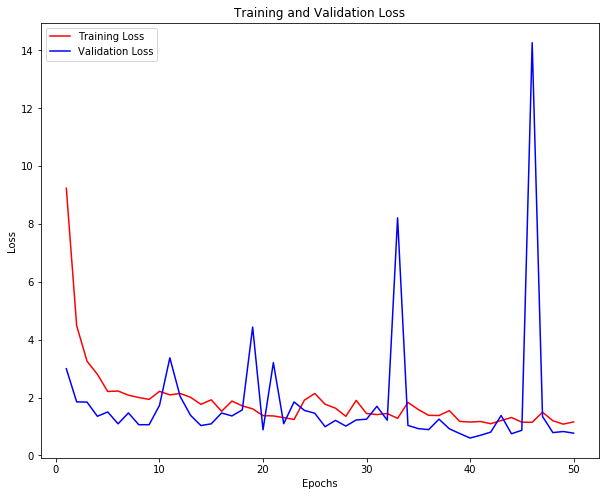

In [8]:
with open('./model/output.txt', 'r') as f:
    line = f.readline()
    line_split = line.split(',')
    train_losses = [float(i) for i in line_split]
    line = f.readline()
    line_split = line.split(',')
    valid_losses = [float(i) for i in line_split]

epoch_range = range(1, len(valid_losses) + 1)
plt.figure(figsize=(10, 8))
plt.plot(epoch_range, train_losses, 'r-', label='Training Loss')
plt.plot(epoch_range, valid_losses, 'b-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Model Inference

In [24]:
def model_inference(_model, _test_loader, _device=torch.device('cpu')):    
    for i, sample in enumerate(_test_loader):        
        images = sample['image']
        key_pts = sample['keypoints']
        images = images.type(torch.FloatTensor).to(_device)
        output_pts = _model(images)        
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)        
        if i == 0:
            return images, output_pts, key_pts

def show_all_keypoints(image, predicted_key_pts, pts=None, axis=None):
    plt.imshow(image, cmap='gray')
    
    X, Y = predicted_key_pts[:, 0], predicted_key_pts[:, 1]
    x_min, x_max = X.min(), X.max()
    y_min, y_max = Y.min(), Y.max()
    width = np.abs(x_max - x_min)
    height = np.abs(y_max - y_min)
    
    plt.scatter(X, Y, s=20, marker='.', c='m')
    rect = patches.Rectangle((x_min, y_min), width, height,linewidth=1,edgecolor='r',facecolor='none')
    axis.add_patch(rect)
    
    if pts is not None:
        plt.scatter(pts[:, 0], pts[:, 1], s=20, marker='.', c='g')
        if axis is not None:
            for i in range(len(pts[:, 0])):
                axis.annotate(str(i), (pts[i, 0], pts[i, 1]))

def visualize_output(images, outputs, pts=None, batch_size=10):
    
    plt.figure(figsize=(20,10))
    for i in range(batch_size):
        ax = plt.subplot(1, batch_size, i + 1)
        image = images[i].data
        image = image.cpu().numpy()   
        image = np.transpose(image, (1, 2, 0))
        predicted_key_pts = outputs[i].data
        predicted_key_pts = predicted_key_pts.cpu().numpy()
        predicted_key_pts = predicted_key_pts * 50.0 + 100
        
        ground_truth_pts = None
        if pts is not None:
            ground_truth_pts = pts[i]         
            ground_truth_pts = ground_truth_pts * 50.0 + 100
        
        show_all_keypoints(np.squeeze(image), predicted_key_pts, pts=ground_truth_pts, axis=ax)
        plt.axis('off')
    plt.show()

/usr/local/Caskroom/miniconda/base/envs/cs435/lib/python3.7/site-packages/torch/serialization.py:559: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "


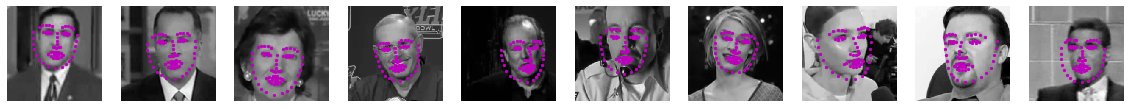

In [10]:
model = torch.load('./model/checkpoint_best.pt', map_location=device)

test_images, test_outputs, gt_pts = model_inference(model, test_loader)

visualize_output(test_images, test_outputs, batch_size=5)